# Image segmentation

In [7]:
import os
import tools
import numpy as np
import scipy
import scipy.stats
import scipy.cluster.vq
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

## Extract features

In [8]:
import numpy as np

def rgb2ycbcr(img):
    """
    It should work the same as Matlab's version
    img should be np.ndarray with dtype = uint8
    value range(img) = [0,255]
    """
    oriT = np.asarray([65.481, 128.553, 24.966, \
            -37.797, -74.203, 112, \
            112, -93.786, -18.214]).reshape((3,3),order='C')/255
    offset = [16, 128, 128]
    img = np.minimum(img, 255)
    resimg = np.zeros(img.shape,dtype=np.float64)
    for i in range(3):
        resimg[:,:,i] = img[:,:,0] * oriT[i,0] + img[:,:,1] * oriT[i,1] + \
          img[:,:,2] * oriT[i,2] + offset[i]
    resimg = np.round(resimg)
    return np.require(resimg,dtype=np.uint8)

def getfeatures(img, stepsize, follow_matlab = True):
    """
    getfeatures - extract features from an image
     [X, L] = getfeatures(img, stepsize)
     INPUT
     img      - the image   [type = np.ndarray or Image]
     stepsize - window stepsize
     OUTPUT
      X   - the features: each column is a feature vector  [type = np.ndarray]
      L   - dictionary containing location information of each feature
    """
    winsize = 7 # ensure it is an odd number
    if stepsize > winsize:
        raise Exception('stepsize larger than window size')
    img = np.asarray(img)
    if img.dtype!= np.uint8 or len(img.shape) != 3:
        raise Exception('only uint8 image color are supported')
    yimg = np.require(rgb2ycbcr(img), dtype=np.float64)
    sy,sx, sc = img.shape
    offset = np.floor((winsize-1)/2)
    rangex = range(0, (sx-winsize+1) , stepsize)
    rangey = range(0, (sy-winsize+1) , stepsize)
    win_max = winsize 
    X = np.zeros((4, len(rangex) * len(rangey)), dtype=np.float64);
    i = 0
    # to compesate the fact that python is 0-index
    py2mat_constant = 1 if follow_matlab else 0
    for x in rangex:
        for y in rangey:
            myIu = yimg[y:y+win_max,x:x+win_max,1]
            myIv = yimg[y:y+win_max,x:x+win_max,2]
            X[:,i] = [np.mean(myIu.flatten()), \
                      np.mean(myIv.flatten()), \
                      y + offset + py2mat_constant, \
                      x + offset + py2mat_constant
                      ]
            i = i + 1 
    L = {'rangex':rangex, 'rangey':rangey, 'offset':offset, 'sx':sx, 'sy':sy, \
         'stepsize':stepsize, 'winsize':winsize, 'follow_matlab':follow_matlab}
    return X, L

## Pixel-level classification with K-means

Kmeans total iters: 9
Kmeans total iters: 15
Kmeans total iters: 17
Kmeans total iters: 10
Kmeans total iters: 10
Kmeans total iters: 13
Kmeans total iters: 8
Kmeans total iters: 21


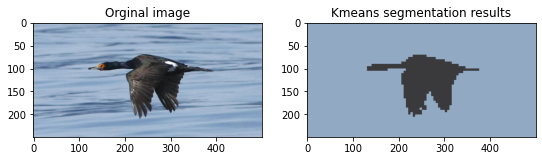

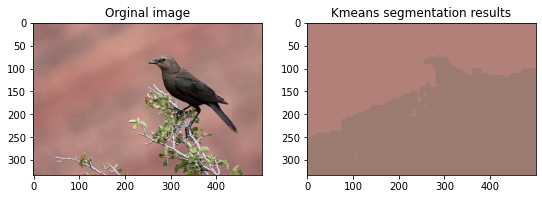

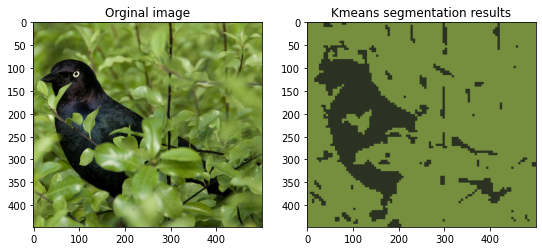

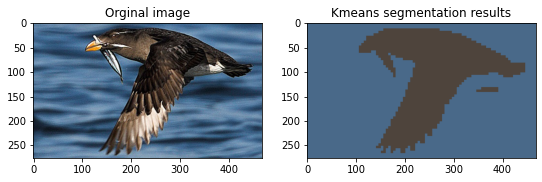

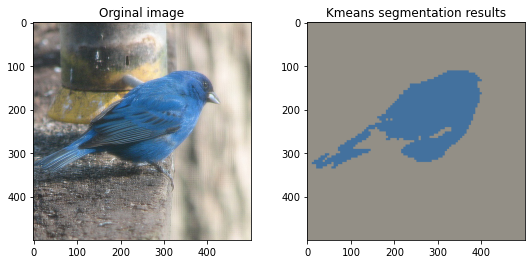

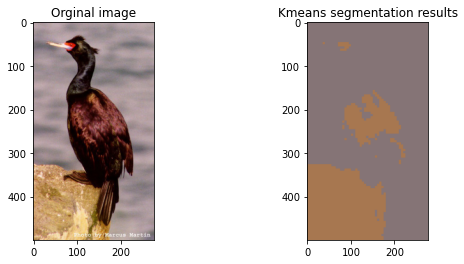

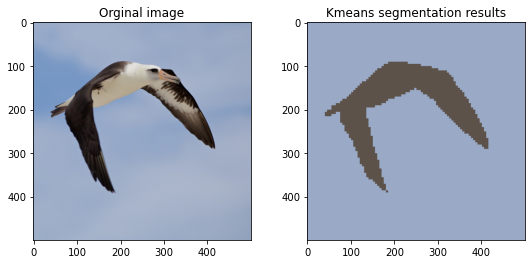

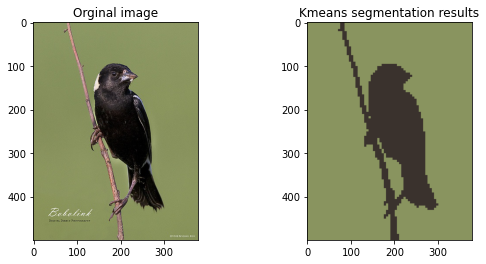

In [9]:
## K-means algorithm
def Kmeans(input, num_classes):
    ##randomly initial cluster centers
    K_centers = np.zeros((num_classes, input.shape[1]))
    for i in range(input.shape[1]):
        Xi_min = np.min(input[:,i])
        Xi_max = np.max(input[:,i])
        K_centers[:,i] = Xi_min + (Xi_max-Xi_min)*np.random.rand(num_classes)
    
    predict_Y = np.zeros(input.shape[0])
    for iters in range(1000): 
        last_centers = np.copy(K_centers)
        counter = np.zeros([num_classes]) 
        for i in range(input.shape[0]):
            xi = input[i,:]
            distance = np.sum((last_centers - xi)**2, axis=1)
            index = np.argmin(distance)
            min_distance = distance[index]
            predict_Y[i] = index
            for k in range(num_classes):
                if predict_Y[i] == k:
                    K_centers[k,:] += xi
                    counter[k] +=1
                else:
                    continue
        for k in range(num_classes): 
            if counter[k] == 0:
                K_centers[k] = last_centers[k]
            else:
                K_centers[k] = K_centers[k]/np.float32(counter[k])
        if np.sum((K_centers-last_centers)**2)==0.0:
            break
    print('Kmeans total iters:',iters)
    return predict_Y 

image_list = os.listdir('./test/')
image_path = './test/'

num_classes = 2
for i in range(int(len(image_list))):
    plt.figure(figsize=(9,4))
    img = np.array(Image.open(image_path+image_list[i]))
    X, L = getfeatures(img, stepsize=5)
    Y_Kmeans = Kmeans(scipy.cluster.vq.whiten(X.T), num_classes)+1
    #orginal image
    plt.subplot(121)
    plt.imshow(img)
    plt.title('Orginal image')
    # kmeans
    plt.subplot(122)
    segm_kmeans = tools.labels2seg(Y_Kmeans, L)
    image_Kmeans = tools.colorsegms(segm_kmeans, img)
    plt.imshow(image_Kmeans)
    plt.title('Kmeans segmentation results')  
#     plt.savefig('./test_results/' + image_list[i], bbox_inches='tight')

## Change Kmeans's num_classes

Kmeans total iters: 7
Kmeans total iters: 8
Kmeans total iters: 51
Kmeans total iters: 26
Kmeans total iters: 12
Kmeans total iters: 22
Kmeans total iters: 44
Kmeans total iters: 22
Kmeans total iters: 19
Kmeans total iters: 23
Kmeans total iters: 33
Kmeans total iters: 42
Kmeans total iters: 17
Kmeans total iters: 17
Kmeans total iters: 17
Kmeans total iters: 30
Kmeans total iters: 32
Kmeans total iters: 18
Kmeans total iters: 24
Kmeans total iters: 51
Kmeans total iters: 11
Kmeans total iters: 10
Kmeans total iters: 11
Kmeans total iters: 57
Kmeans total iters: 8
Kmeans total iters: 20
Kmeans total iters: 20
Kmeans total iters: 22
Kmeans total iters: 20
Kmeans total iters: 16
Kmeans total iters: 41
Kmeans total iters: 62


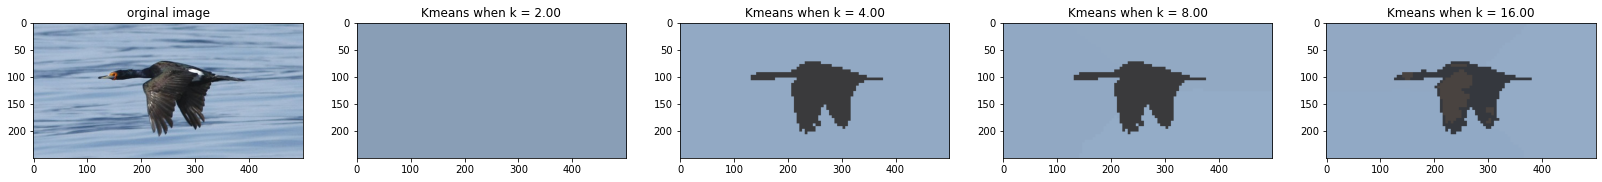

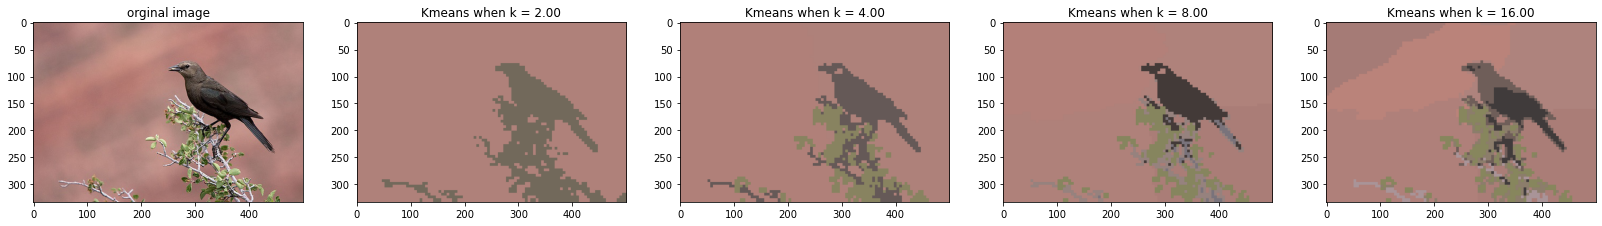

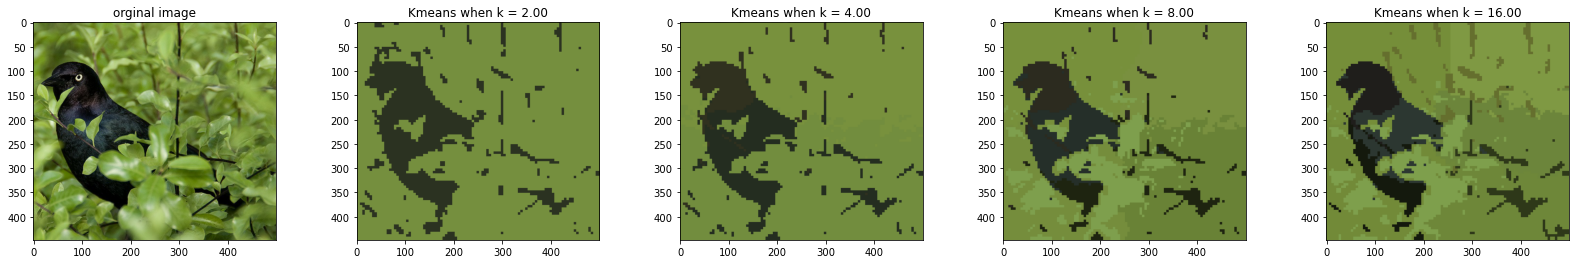

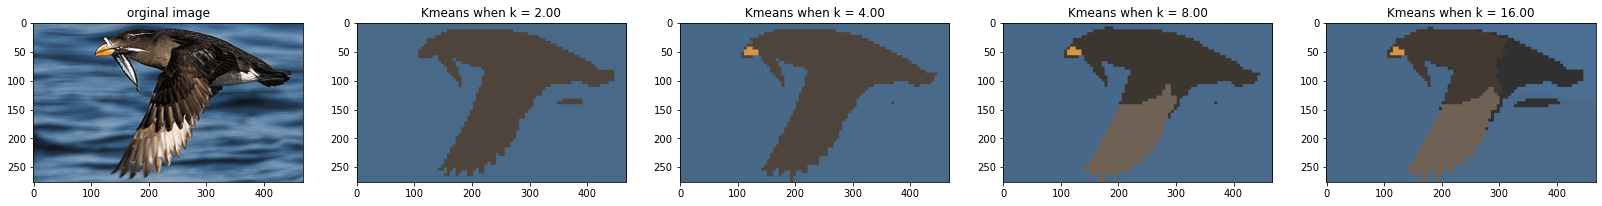

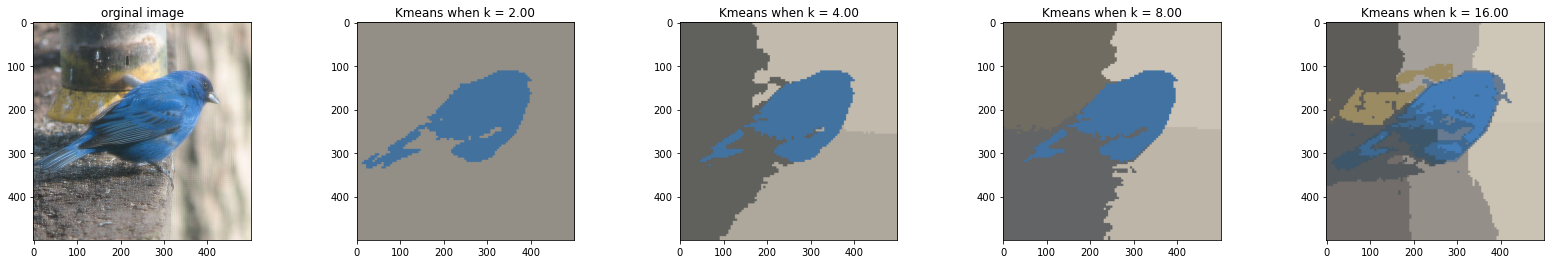

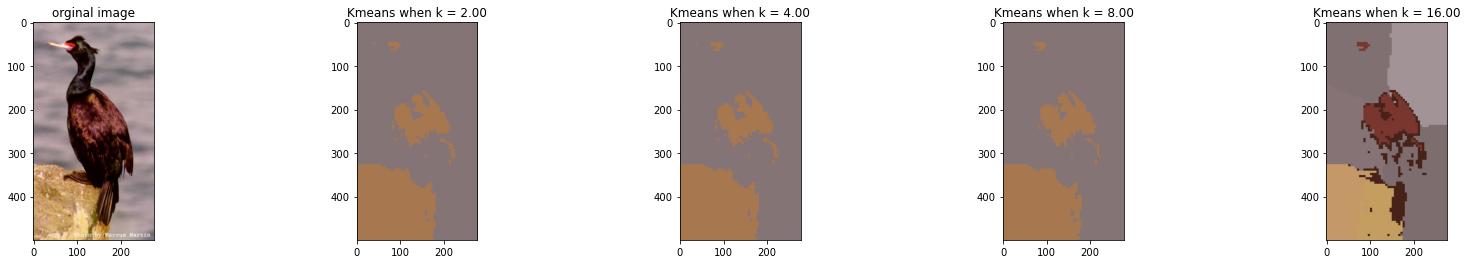

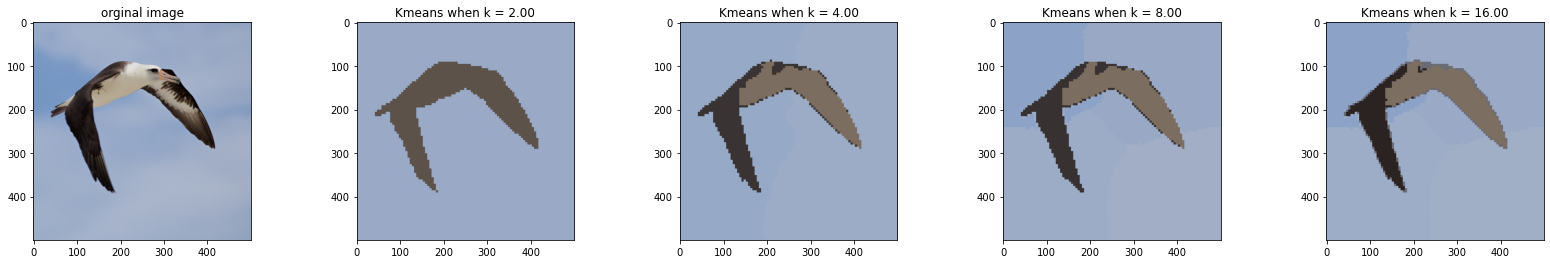

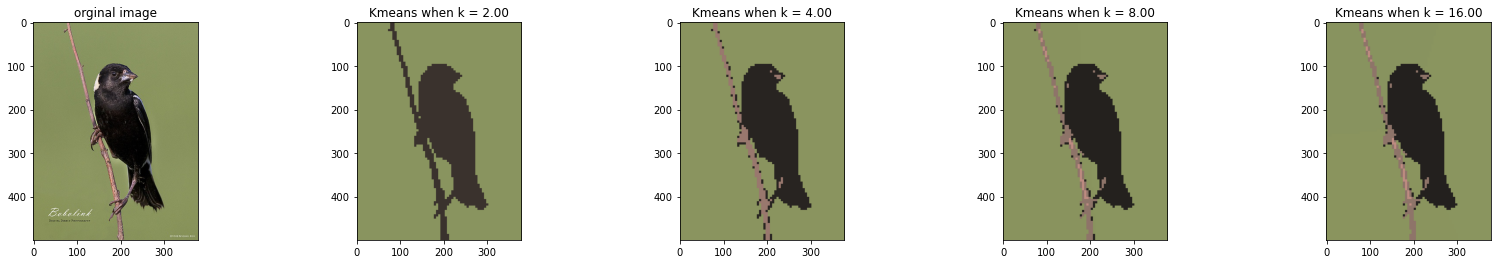

In [10]:
num_classes = [2,4,8,16]
for i in range(len(image_list)):      
    img = np.array(Image.open(image_path+image_list[i]))
    X, L = getfeatures(img, stepsize=5)    
    plt.figure(figsize=(28,4))
    plt.subplot(1,5,1)
    plt.imshow(img)
    plt.title('orginal image')
    for k in range(len(num_classes)):
        segm = tools.labels2seg(Kmeans(scipy.cluster.vq.whiten(X.T), num_classes[k])+1, L)
        csegm = tools.colorsegms(segm, img)
        plt.subplot(1,5,k+2)
        plt.imshow(csegm)
        plt.title('Kmeans when k = %.2f'%num_classes[k])    

## Modify K-means by changing the distance function

Kmeans total iters: 5
Kmeans total iters: 6
Kmeans total iters: 7
Kmeans total iters: 8
Kmeans total iters: 15
Kmeans total iters: 13
Kmeans total iters: 14
Kmeans total iters: 10
Kmeans total iters: 14
Kmeans total iters: 13
Kmeans total iters: 18
Kmeans total iters: 19
Kmeans total iters: 9
Kmeans total iters: 12
Kmeans total iters: 12
Kmeans total iters: 12
Kmeans total iters: 13
Kmeans total iters: 11
Kmeans total iters: 9
Kmeans total iters: 10
Kmeans total iters: 12
Kmeans total iters: 10
Kmeans total iters: 11
Kmeans total iters: 9
Kmeans total iters: 7
Kmeans total iters: 8
Kmeans total iters: 7
Kmeans total iters: 8
Kmeans total iters: 16
Kmeans total iters: 18
Kmeans total iters: 10
Kmeans total iters: 18


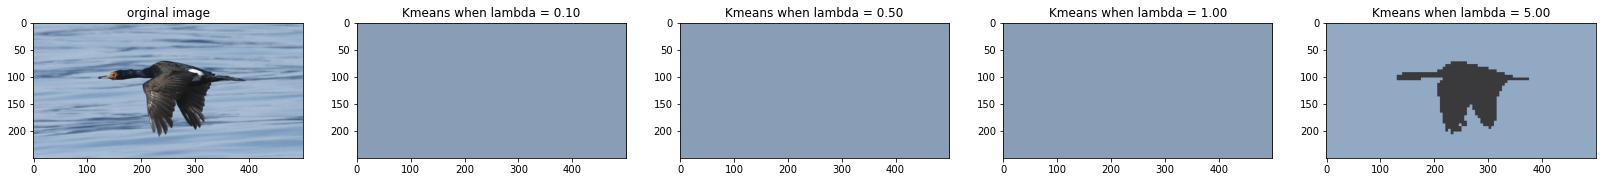

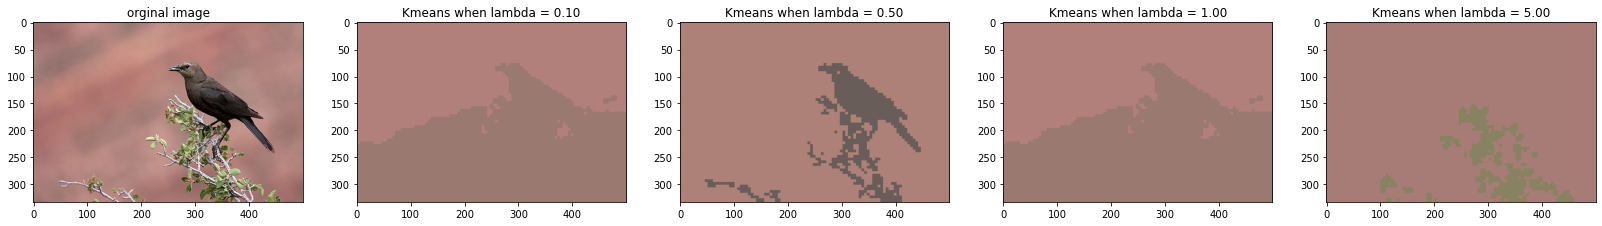

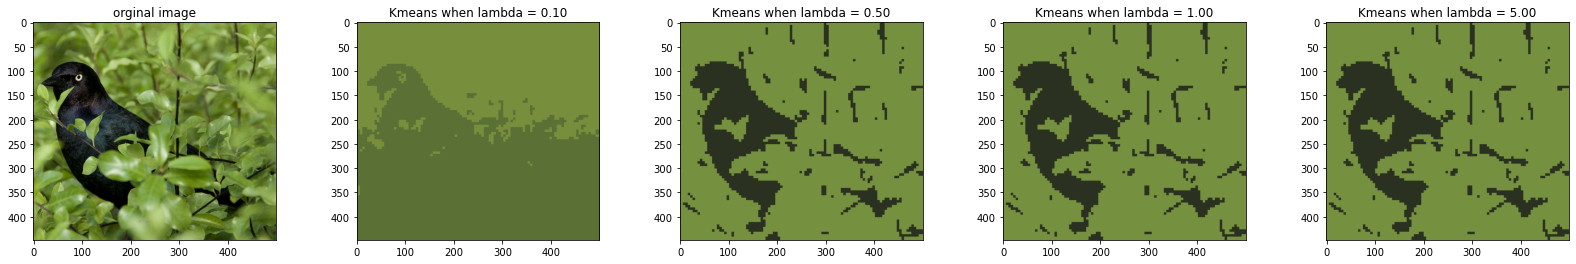

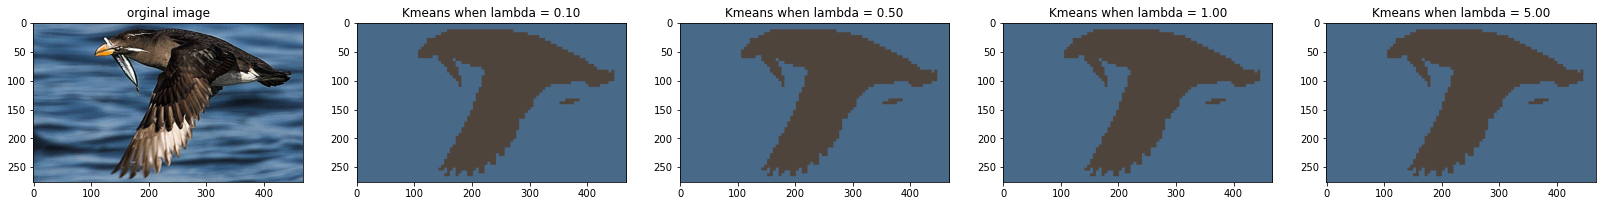

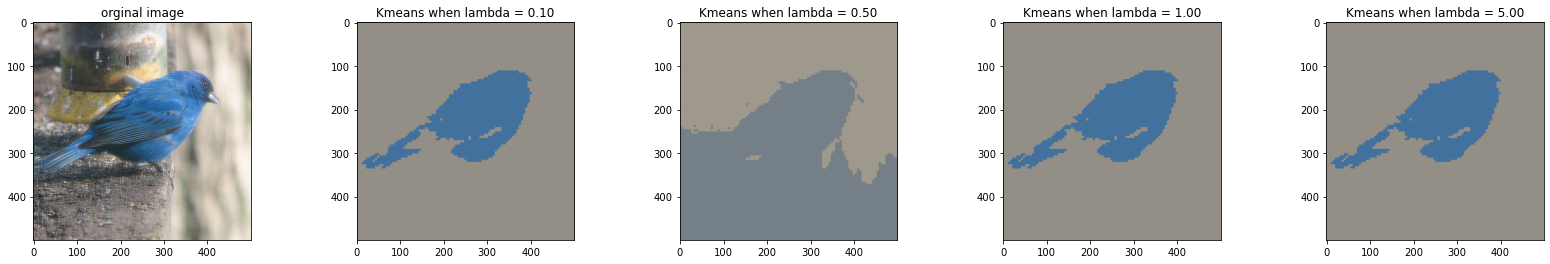

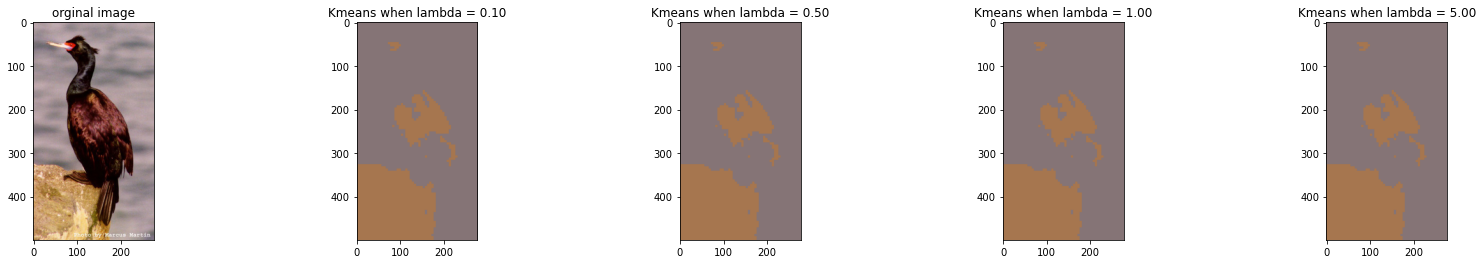

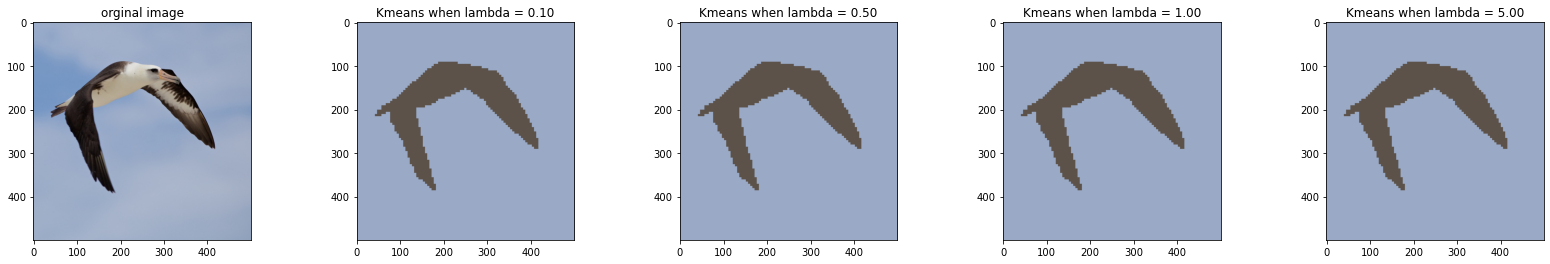

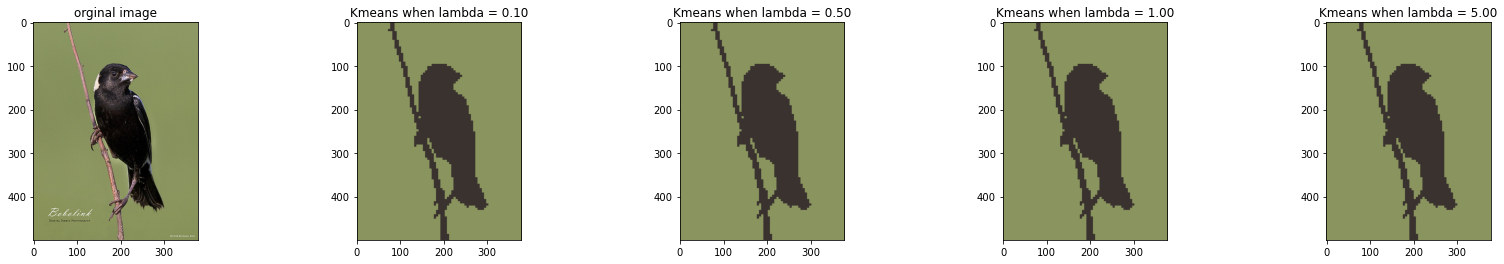

In [11]:
Lambda = [0.1, 0.5, 1, 5]
num_classes = 2
for i in range(len(image_list)):
    img = Image.open(image_path+image_list[i])
    X, L = getfeatures(img, stepsize=5)  
    plt.figure(figsize=(28,4))
    plt.subplot(1,5,1)
    plt.imshow(img)
    plt.title('orginal image')
    for l in range(len(Lambda)):
        X_hat = np.concatenate((X.T[:,0:2], Lambda[l]*X.T[:,2:-1]), axis=1) # scaling features
        Y_Kmeans = Kmeans(scipy.cluster.vq.whiten(X_hat), num_classes)+1
        segm = tools.labels2seg(Y_Kmeans, L)
        csegm = tools.colorsegms(segm, img)
        plt.subplot(1,5,l+2)
        plt.imshow(csegm)
        plt.title('Kmeans when lambda = %.2f'%Lambda[l])